# 사전 학습된 CNN(VGG-16)을 이용한 Feature Extraction

## VGG-16 Model
  * University of Oxford - Visual Geometry Group
  * 2014 ILSVRC 2nd Model
  * ImageNet Large Scale Visual recognition Challenge (ILSVRC)

# Import Keras

In [1]:
import keras

keras.__version__

'2.4.3'

# I. Google Drive Mount

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 마운트 결과 확인
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'

-rw------- 1 root root 90618980 Mar  4 04:51 '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'


In [4]:
# unzip
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/dogs_and_cats_small.zip


Archive:  /content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip
  inflating: test/cats/cat.1501.jpg  
  inflating: test/cats/cat.1502.jpg  
  inflating: test/cats/cat.1503.jpg  
  inflating: test/cats/cat.1504.jpg  
  inflating: test/cats/cat.1505.jpg  
  inflating: test/cats/cat.1506.jpg  
  inflating: test/cats/cat.1507.jpg  
  inflating: test/cats/cat.1508.jpg  
  inflating: test/cats/cat.1509.jpg  
  inflating: test/cats/cat.1510.jpg  
  inflating: test/cats/cat.1511.jpg  
  inflating: test/cats/cat.1512.jpg  
  inflating: test/cats/cat.1513.jpg  
  inflating: test/cats/cat.1514.jpg  
  inflating: test/cats/cat.1515.jpg  
  inflating: test/cats/cat.1516.jpg  
  inflating: test/cats/cat.1517.jpg  
  inflating: test/cats/cat.1518.jpg  
  inflating: test/cats/cat.1519.jpg  
  inflating: test/cats/cat.1520.jpg  
  inflating: test/cats/cat.1521.jpg  
  inflating: test/cats/cat.1522.jpg  
  inflating: test/cats/cat.1523.jpg  
  inflating: test/cats/cat.1524.jpg  
  inf

In [5]:
!ls -l

total 20
drwx------ 5 root root 4096 Mar 24 05:29 drive
drwxr-xr-x 1 root root 4096 Mar 18 13:36 sample_data
drwxr-xr-x 4 root root 4096 Mar 24 05:29 test
drwxr-xr-x 4 root root 4096 Mar 24 05:29 train
drwxr-xr-x 4 root root 4096 Mar 24 05:29 validation


# II. Image_File Directory Setting

In [6]:
train_dir = 'train'
valid_dir = 'validation'
test_dir = 'test'


# III. Import VGG-16 Model

> ## 1) conv_base

In [7]:
from keras.applications import VGG16
conv_base = VGG16(weights = 'imagenet',
                  include_top =False,
                  input_shape = (150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


> ## 2) Model Information

In [8]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# IV. Feature Extraction

> ## 1) 특징추출 함수 정의: extract feature()

In [9]:
# conv_base.predict()
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count))


    generator = datagen.flow_from_directory(directory,
                                          target_size = (150, 150),
                                          batch_size = batch_size,
                                          class_mode = 'binary')
  
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

> ## 2) 특징 추출 함수 적용

In [10]:
%%time

train_features, train_labels = extract_features(train_dir, 2000)
valid_features, valid_labels = extract_features(valid_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
CPU times: user 23.9 s, sys: 6.49 s, total: 30.3 s
Wall time: 59.4 s


In [11]:
train_features.shape, valid_features.shape, test_features.shape

((2000, 4, 4, 512), (1000, 4, 4, 512), (1000, 4, 4, 512))

> ## 3) Reshape Features

In [12]:
# for 'Classification Network

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
valid_features = np.reshape(valid_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

train_features.shape, valid_features.shape, test_features.shape

((2000, 8192), (1000, 8192), (1000, 8192))

# V. Keras CNN Modeling with VGG-16 Featured Data

> ## 1) Model Define

* 'Classification' Network Only
* Dropout Layer

In [13]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4* 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


> ## 2) Model Compile 

In [15]:
# 모델 학습방법 설정

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

> ## 3) Model Fit

In [16]:
%%time
Hist_dandc = model.fit(train_features, train_labels,
                       epochs = 100,
                       batch_size = 20,
                       validation_data = (valid_features, valid_labels))

Epoch 1/100
100/100 [==============================] - 1s 7ms/step - loss: 0.7432 - accuracy: 0.7010 - val_loss: 0.2670 - val_accuracy: 0.8930
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 0.2730 - accuracy: 0.8838 - val_loss: 0.2618 - val_accuracy: 0.8900
Epoch 3/100
100/100 [==============================] - 0s 4ms/step - loss: 0.2000 - accuracy: 0.9239 - val_loss: 0.2644 - val_accuracy: 0.8930
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 0.1672 - accuracy: 0.9413 - val_loss: 0.2589 - val_accuracy: 0.8870
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 0.1284 - accuracy: 0.9506 - val_loss: 0.2548 - val_accuracy: 0.9000
Epoch 6/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0965 - accuracy: 0.9614 - val_loss: 0.2759 - val_accuracy: 0.8890
Epoch 7/100
100/100 [==============================] - 0s 3ms/step - loss: 0.1065 - accuracy: 0.9595 - val_loss: 0.2651 - val_accuracy: 0.9030

> ## 4) 학습 결과 시각화

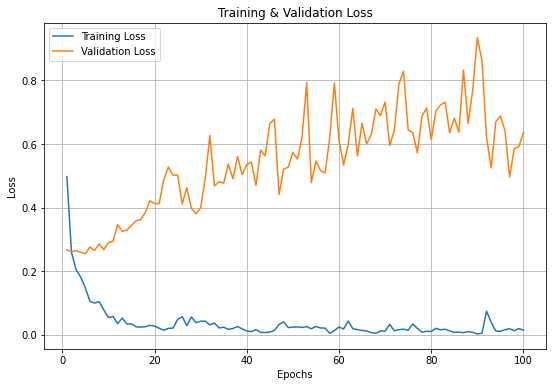

In [17]:
# Loss Visualization

import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['loss'])
plt.plot(epochs, Hist_dandc.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()


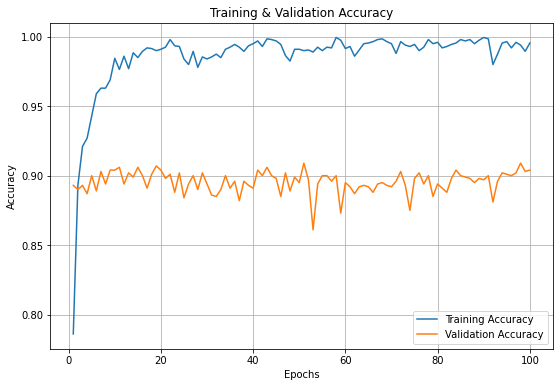

In [18]:
# Accuracy Visualization

import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['accuracy'])
plt.plot(epochs, Hist_dandc.history['val_accuracy'])

plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()



> ## 5) Model Evaluate

In [19]:
# Loss & Accruacy

loss, accuracy = model.evaluate(test_features, test_labels)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))


32/32 [==============================] - 0s 2ms/step - loss: 0.6786 - accuracy: 0.8840
Loss = 0.67857
Accuracy = 0.88400


# IV. Model Save & Load to Google Drive

> ## 1) Google Drive Mount

In [20]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


> ## 2) Model Save

In [21]:
model.save('/content/drive/My Drive/Colab Notebooks/models/004_dogs_and_cats_feature_extraction.h5')

!ls -l /content/drive/My\ Drive/Colab\ Notebooks/models

total 104116
-rw------- 1 root root    34592 Mar 17 07:36 001_Model_iris.h5
-rw------- 1 root root 39879924 Mar 23 04:48 002_dogs_and_cats_small.h5
-rw------- 1 root root 41499744 Mar 23 06:39 003_dogs_and_cats_augmentation.h5
-rw------- 1 root root 25199032 Mar 24 05:31 004_dogs_and_cats_feature_extraction.h5


> ## 3) Model Load

In [22]:
from keras.models import load_model

model_google = load_model('/content/drive/My Drive/Colab Notebooks/models/004_dogs_and_cats_feature_extraction.h5')

loss, accuracy = model_google.evaluate(test_features, test_labels)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

32/32 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.8840
Loss = 0.67857
Accuracy = 0.88400
